In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wrangle as w
import explore as ex
from importlib import reload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Screaming into your Zillow
### predicting tax_value of housing from previous predictions

# Goals
- Determine driving factors of tax value of houses sold in 2016
- Use those factors to build a model to predict housing places
- Use that model to attempt to predict the tax value of houses

# Acquire
* Data acquired from CodeUp Database
* Did initial exploratory analysis within SQL.
* Identified columns with minimal null values which showed promise for modeling.
* Before cleaning, data had 52442 rows and 8 columns (See Data Dictionary for columns selected)
* Each row represents a property which had a prediction run by Zillow's model
* Each column represents a feature of that property

In [24]:
reload(w)
df = w.wrangle_zillow(flag='sql')
train,validate,test = w.tvt_split(df)

# Prepare
### Preparation actions:
- dropped null values in `calc_sqft, tax_value` and `year_built`
- removed homes with 0 bedrooms or bathrooms. That's not a house, that's a shed.
- filled `NaN` values (~in `full_baths` with rounded-down `bath_count` (most houses only have one half bath).
- engineered `half_baths` column as `bath_count - full_baths`
- changed data types to from floating point to integer as appropriate
- Removed Outliers, including houses with more than 8 bathrooms, 7 bathrooms, 7 half baths, or which had a valuation over $3,500,000. These values were chosen to limit data loss

# Explore
## A look at the data:

In [10]:
train.head()

,tax_value,bed_count,bath_count,full_baths,calc_sqft,year_built,fips,half_baths
51971,648788.0,5,4.0,4,3300.0,1950,6037,0
8847,876059.0,3,2.0,2,1761.0,1952,6037,0
32073,806181.0,3,3.0,3,2605.0,1994,6059,0
630,222816.0,4,2.0,2,1075.0,1954,6037,0
1203,2847720.0,4,4.5,4,3912.0,2004,6059,1


In [11]:
train.describe()

,tax_value,bed_count,bath_count,full_baths,calc_sqft,year_built,fips,half_baths
count,2.890700e+04,28907.000000,28907.000000,28907.000000,28907.000000,28907.000000,28907.000000,28907.000000
mean,4.812760e+05,3.291798,2.275521,2.211644,1884.534784,1963.313384,6049.011278,0.127755
std,4.516579e+05,0.915999,0.956780,0.931605,897.859687,23.042771,20.915913,0.337225
min,3.254000e+03,1.000000,1.000000,1.000000,326.000000,1880.000000,6037.000000,0.000000
25%,1.921285e+05,3.000000,2.000000,2.000000,1263.000000,1950.000000,6037.000000,0.000000
50%,3.692820e+05,3.000000,2.000000,2.000000,1648.000000,1960.000000,6037.000000,0.000000
75%,6.048825e+05,4.000000,3.000000,3.000000,2280.000000,1979.000000,6059.000000,0.000000
max,3.496000e+06,8.000000,7.500000,7.000000,11020.000000,2015.000000,6111.000000,3.000000


## Is there a linear correlation between calculated square feet and tax value?

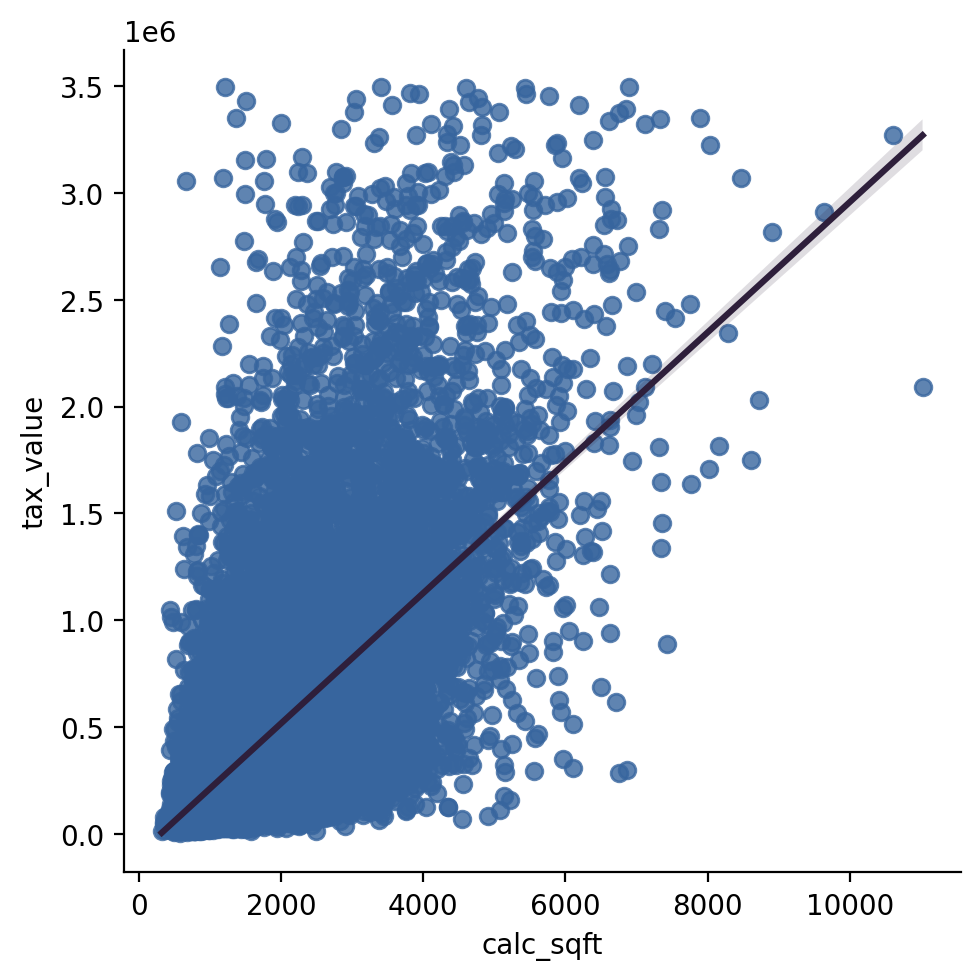

In [15]:
reload(ex)
ex.plot_1(train)

## Is there a linear correlation between tax_value and calc_sqft?
$H_0$: There is no linear correlations between tax_value and calc_sqft

$H_a$ There is a linear correlation between tax_value and calc_sqft

In [16]:
ex.tax_sqft_test(train)

## r = 0.5150142490142886

## p = 0.0

## Because $\alpha$ > p,we  reject $H_0$

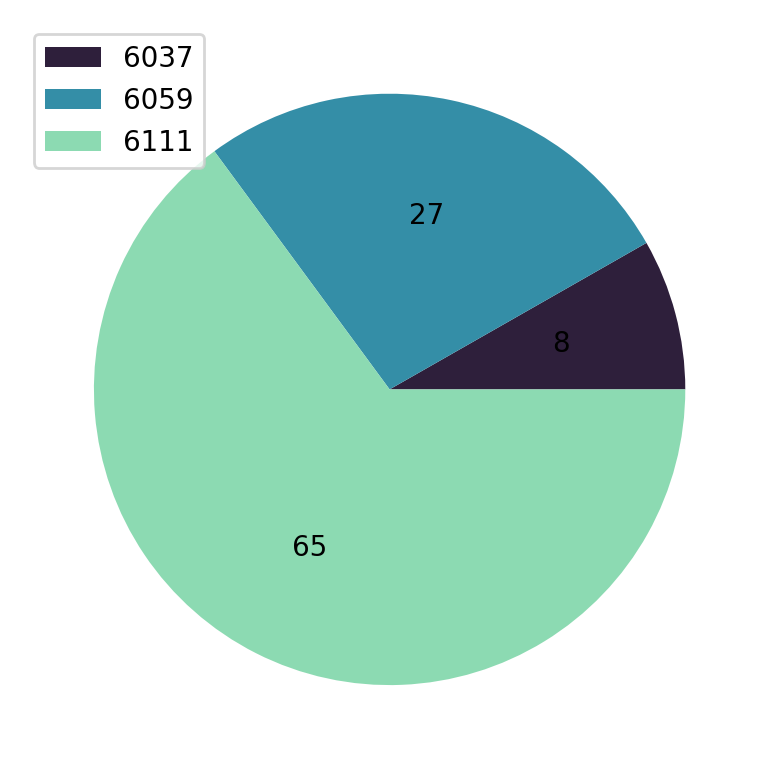

In [22]:
reload(ex)
ex.obligatory_pie_chart(train)

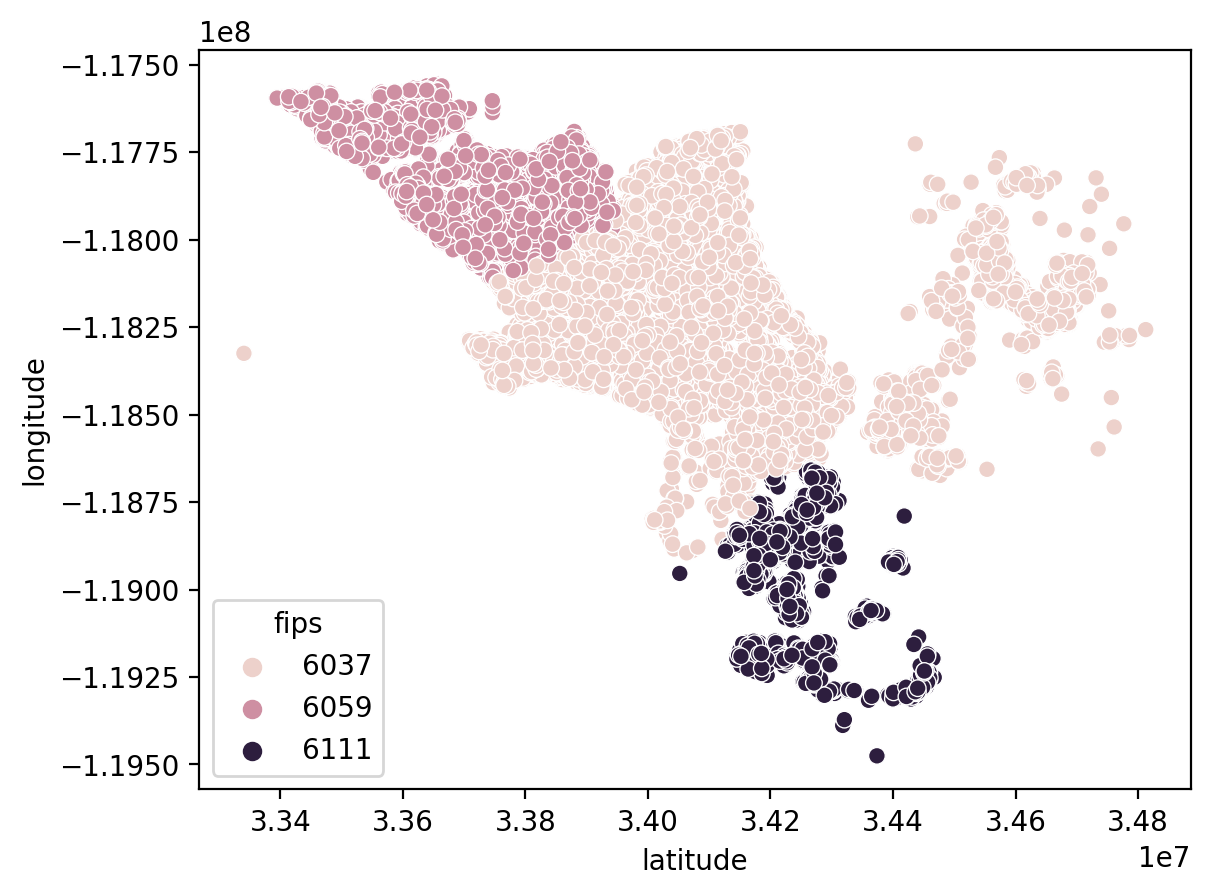

In [30]:
reload(ex)
ex.lat_long(train)